# Continuous Control


In this notebook we solve continuous control environment using [Soft Actor-Critic (SAC)](https://arxiv.org/pdf/1801.01290.pdf). It's an off-policy algorith that is still go-to algorithm for continuous control tasks.

## Environment

In [ ]:
import gymnasium as gym
import numpy as np

In [ ]:
env = gym.make("Ant-v5", render_mode="rgb_array", include_cfrc_ext_in_observation=False)

# we want to look inside
env.reset()

# examples of states and actions
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset()[0])
print("action space: ", env.action_space,
      "\naction_sample: ", env.action_space.sample())

observation space:  Box(-inf, inf, (27,), float64) 
observations: [ 0.68390503  0.93225278 -0.05288056 -0.09177807 -0.00444442  0.09714552
  0.00318961 -0.03715797 -0.03973656 -0.01613677  0.05449561  0.04882956
  0.01281292  0.03819091 -0.09218437  0.05535422  0.13643082  0.01176172
 -0.25634703 -0.057596    0.25733553 -0.09843272 -0.13296107  0.00390252
  0.07754583  0.14418847 -0.06044891]
action space:  Box(-1.0, 1.0, (8,), float32) 
action_sample:  [ 0.2823781  -0.36251137  0.82560205 -0.65247566 -0.7066257  -0.56791794
 -0.8123599   0.6402647 ]


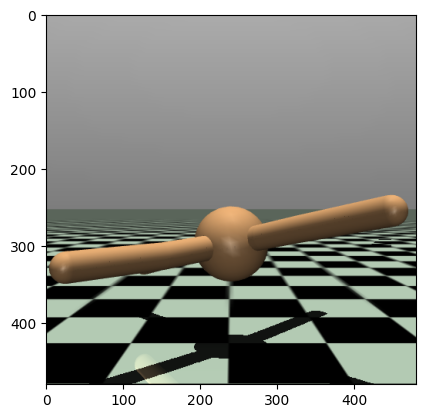

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(env.render())

In [ ]:
from logger import TensorboardSummaries as Summaries

env = gym.make("Ant-v5", render_mode="rgb_array", include_cfrc_ext_in_observation=False)
env = Summaries(env, "MyFirstAnt");

state_dim = env.observation_space.shape[0]  # dimension of state space (27 numbers)
action_dim = env.action_space.shape[0]      # dimension of action space (8 numbers)

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/td3_and_sac/logger.py

    !pip -q install gymnasium[mujoco]==1.0.0
    !pip -q install tensorboardX

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

## Models

### critic model


In [ ]:
import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.h = 64
        self.model  = nn.Sequential(
                            nn.Linear(state_dim + action_dim, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, 1))


    def get_qvalues(self, states, actions):
        '''
        input:
            states - tensor, (batch_size x features)
            actions - tensor, (batch_size x actions_dim)
        output:
            qvalues - tensor, critic estimation, (batch_size)
        '''
        states = torch.tensor(states, dtype=torch.float32, device="cuda")
        #actions = torch.tensor(actions, dtype=torch.float32, device="cuda")
        input = torch.cat([states, actions], dim=1)
        qvalues = self.model(input).squeeze()

        assert len(qvalues.shape) == 1 and qvalues.shape[0] == states.shape[0]

        return qvalues

### Actor model

In [ ]:
from torch.distributions import Normal
from torch.nn import functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.h = 64
        self.action_dim = action_dim
        self.model  = nn.Sequential(
                            nn.Linear(state_dim, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, self.h),
                            nn.Tanh(),
                            nn.Linear(self.h, 2 * action_dim))

    def apply(self, states):
        '''
        For given batch of states samples actions and also returns its log prob.
        input:
            states - PyTorch tensor, (batch_size x features)
        output:
            actions - PyTorch tensor, (batch_size x action_dim)
            log_prob - PyTorch tensor, (batch_size)
        '''
        inputs = torch.tensor(states, dtype=torch.float32, device="cuda")
        output = self.model(inputs)
        mean, std = torch.split(output, self.action_dim, dim=-1)
        std = F.softplus(std)
        normal_distr = Normal(mean, std ** 2)

        u = normal_distr.rsample()
        tanh = nn.Tanh()
        actions = tanh(u)
        log_prob_u = normal_distr.log_prob(u + 1e-6)
        log_prob_a = log_prob_u.sum(dim=-1) - torch.log(1 - tanh(u) ** 2 + 1e-6).sum(dim=-1).squeeze()

        return actions, log_prob_a

    def get_action(self, states):
        '''
        Used to interact with environment by sampling actions from policy
        input:
            states - numpy, (batch_size x features)
        output:
            actions - numpy, (batch_size x actions_dim)
        '''
        # no gradient computation is required here since we will use this only for interaction
        with torch.no_grad():

            # hint: you can use `apply` method here
            actions = self.apply(states)[0].cpu().numpy()

            assert isinstance(actions, (list,np.ndarray)), "convert actions to numpy to send into env"
            assert actions.max() <= 1. and actions.min() >= -1, "actions must be in the range [-1, 1]"
            return actions

## ReplayBuffer

interface:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [ ]:
from collections import deque

class ReplayBuffer():
    def __init__(self, size):
        """
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """

        self.storage = deque()
        self.size = size

    def __len__(self):
        return len(self.storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)
        self.storage.append(data)
        if len(self)> self.size:
            self.storage.popleft()
        # add data to storage

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        ind = np.random.choice(len(self.storage), size = batch_size, replace = False)
        states = np.stack([self.storage[i][0] for i in ind])
        actions = np.stack([self.storage[i][1] for i in ind])
        rewards = np.stack([self.storage[i][2] for i in ind])
        next_states = np.stack([self.storage[i][3] for i in ind])
        is_done = np.stack([self.storage[i][4] for i in ind])

        return states, actions, rewards, next_states, is_done


In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    s = initial_state
    sum_rewards = 0
    # Play the game for n_steps as per instructions above
    for t in range(n_steps):
        # select action using policy with exploration
        a = agent.get_action(s)
        ns, r, terminated, truncated, _ = env.step(a)
        exp_replay.add(s, a, r, ns, terminated)
        s = env.reset()[0] if terminated or truncated else ns
        sum_rewards += r
    return sum_rewards, s

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Initialization

In [ ]:
gamma=0.99                    # discount factor
max_buffer_size = 10**5       # size of experience replay
start_timesteps = 5000        # size of experience replay when start training
timesteps_per_epoch=1         # steps in environment per step of network updates
batch_size=128                # batch size for all optimizations
max_grad_norm=10              # max grad norm for all optimizations
tau=0.005                     # speed of updating target networks
policy_update_freq=1          # frequency of actor update; vanilla choice is 1 for SAC
alpha=0.1                     # temperature for SAC

# iterations passed
n_iterations = 0

In [ ]:
# experience replay
exp_replay = ReplayBuffer(max_buffer_size)

Here is our models: *two* critics and one actor.

In [ ]:
actor = Actor(state_dim, action_dim).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

To stabilize training, we will require **target networks** - slow updating copies of our models. In **SAC** it is assumed that only critics require target copies while actor is always used fresh.

In [ ]:
# target networks: slow-updated copies of actor and two critics
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())

<All keys matched successfully>

In continuous control, target networks are usually updated using exponential smoothing:
$$\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-},$$
where $\theta^{-}$ are target network weights, $\theta$ - fresh parameters, $\tau$ - hyperparameter. This util function will do it:

In [ ]:
def update_target_networks(model, target_model):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [ ]:
# optimizers:
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

In [ ]:
def optimize(name, model, optimizer, loss):
    '''
    One step of SGD optimization
    '''
    loss = loss.mean()
    optimizer.zero_grad(set_to_none=True) #
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    # logging
    env.writer.add_scalar(name, loss.item(), n_iterations)
    env.writer.add_scalar(name + "_grad_norm", grad_norm.item(), n_iterations)

## Critic target computation

In [ ]:
def compute_critic_target(rewards, next_states, is_done, alpha):
    with torch.no_grad():
        next_actions, log_prob = actor.apply(next_states)
        q_values_1 = target_critic1.get_qvalues(next_states, next_actions)
        q_values_2 = target_critic2.get_qvalues(next_states, next_actions)
        critic_target = rewards + (1 - is_done) * gamma * (torch.min(q_values_1, q_values_2) - alpha * log_prob)
    return critic_target

In [ ]:
def compute_actor_loss(states, alpha):
    actions, log_prob = actor.apply(states)
    # compute actor loss
    actor_loss = -torch.mean(critic1.get_qvalues(states, actions) - alpha * log_prob)
    return actor_loss

# Pipeline

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
from tqdm.notebook import trange

interaction_state, _ = env.reset()
random_actor = RandomActor()
history_norm = []
for n_iterations in trange(0, 700000, timesteps_per_epoch):
    # if experience replay is small yet, no training happens
    # we also collect data using random policy to collect more diverse starting data
    if len(exp_replay) < start_timesteps:
        _, interaction_state = play_and_record(interaction_state, random_actor, env, exp_replay, timesteps_per_epoch)
        continue

    # perform a step in environment and store it in experience replay

    norm = 0
    for layer in actor.parameters():
        norm += (layer ** 2).sum()
    history_norm.append(norm.clone().detach().cpu().numpy())
    _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

    # sample a batch from experience replay
    states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)

    # move everything to PyTorch tensors
    states = torch.tensor(states, device=DEVICE, dtype=torch.float)
    actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
    rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
    next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=DEVICE,
        dtype=torch.float
    )

    # losses
    targets = compute_critic_target(rewards, next_states, is_done, alpha)
    critic1_values = critic1.get_qvalues(states, actions)
    critic2_values = critic2.get_qvalues(states, actions)

    critic1_loss = torch.mean((critic1_values - targets) ** 2 )
    optimize("critic1", critic1, opt_critic1, critic1_loss)

    critic2_loss = torch.mean((critic2_values - targets) ** 2)
    optimize("critic2", critic2, opt_critic2, critic2_loss)

    if n_iterations % policy_update_freq == 0:
        actor_loss = compute_actor_loss(states, alpha)
        optimize("actor", actor, opt_actor, actor_loss)

        # update target networks
        update_target_networks(critic1, target_critic1)
        update_target_networks(critic2, target_critic2)

## Evaluation

In [ ]:
def evaluate(env, actor, n_games=1, t_max=1000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        R = 0
        for _ in range(t_max):
            action = actor.get_action(s)
            s, r, terminated, truncated, _ = env.step(action)
            R += r
            if terminated or truncated:
                break
        rewards.append(R)
    return np.array(rewards)

In [ ]:
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

assert score >= 1000, "Needs more training?"
print("Well done!")

Your score: 1812.0645780622247
Well done!


In [ ]:
env.close()